<a href="https://colab.research.google.com/github/darockz659/ideal-octo-giggle/blob/master/Copy_of_Copy_of_A_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREREQUISITES**

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm
#from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from datetime import datetime 
from PIL import Image
from keras import backend, optimizers
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/OUHANDS/OUHANDS.zip'

Streaming output truncated to the last 5000 lines.
  inflating: archive/OUHANDS_train/train/negative_data/colour/1825.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1826.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1827.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1828.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1829.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1830.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1831.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1832.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1833.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1834.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1835.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1836.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1837.png  


**DATA** **LOADER**

In [ ]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [ ]:
path = '/content/archive/OUHANDS_train/train/hand_data/colour'

maskpath ='/content/archive/OUHANDS_train/train/hand_data/segmentation'

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))

print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:04<00:00, 418.42it/s]


In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
X_train.shape

(2000, 320, 320, 3)

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
x = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [ ]:
def conv_block(x, filter_size, size, dropout=0.1, batch_norm=True):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


In [ ]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    
    model = tf.keras.Model(inputs=[inputs], outputs=[conv_final])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#Model Checkpoint
checkpoint_path_recog = "/content/drive/MyDrive/OUHANDS/A-Unet/checkp.ckpt"
model_checkpoint_recog = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_recog,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
model = Attention_UNet(input_shape, 1, 0.1, True)

In [ ]:
OUTPUT = model.fit(X_train,Y_train,validation_split = 0.1,batch_size=2,epochs=3,callbacks=[model_checkpoint_recog])

Epoch 1/3
900/900 [==============================] - 818s 895ms/step - loss: 0.3168 - accuracy: 0.9595 - val_loss: 0.2508 - val_accuracy: 0.9559

Epoch 00001: val_accuracy improved from 0.87546 to 0.95592, saving model to /content/drive/MyDrive/OUHANDS/A-Unet/checkp.ckpt
Epoch 2/3
900/900 [==============================] - 803s 892ms/step - loss: 0.1678 - accuracy: 0.9766 - val_loss: 0.1233 - val_accuracy: 0.9789

Epoch 00002: val_accuracy improved from 0.95592 to 0.97891, saving model to /content/drive/MyDrive/OUHANDS/A-Unet/checkp.ckpt
Epoch 3/3
900/900 [==============================] - 802s 891ms/step - loss: 0.1091 - accuracy: 0.9798 - val_loss: 0.0958 - val_accuracy: 0.9784

Epoch 00003: val_accuracy did not improve from 0.97891


In [ ]:
pred_train=model.predict(X_train[:int(X_train.shape[0])],verbose=1)

pred_train_t = (pred_train>0.5).astype(np.uint8)

ResourceExhaustedError: ignored

In [ ]:
for i in range(pred_train_t.shape[0]):
  name="seg"+str(i)+".jpg"
  img=np.reshape(pred_train_t[i],(IMG_HEIGHT,IMG_WIDTH))
  img=255*img
  cv2.imwrite(name,img)

In [ ]:
for i in range(pred_train_t.shape[0]):
  name="mask"+str(i)+".jpg"
  img=np.reshape(Y_train[i],(IMG_HEIGHT,IMG_WIDTH))
  img=255*img
  cv2.imwrite(name,img)

In [ ]:
!ls

archive  drive	sample_data


In [ ]:
X_train.shape

(2000, 320, 320, 3)

In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
path = "/content/archive/OUHANDS_test/test/hand_data/colour"
maskpath = "/content/archive/OUHANDS_test/test/hand_data/segmentation"

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    X_test[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:02<00:00, 409.15it/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import f1_score

In [ ]:
def fscore(tp,Images,Masks):
    total=0
    i=0
    fs=0
    for i in range(len(Images)):
        total += 1
        
        tp[i][tp[i]>0.5]=1
        tp[i][tp[i]<0.5]=0

        pred = img_to_array(tp[i]).astype(int)
        label = img_to_array(np.squeeze(Masks[i], axis=2)).astype(int)
        flat_pred = np.ravel(pred)
        flat_label = np.ravel(label)

        fs += f1_score(flat_label,flat_pred, average='micro')

    fs=fs/total

    return fs  

In [ ]:
 #    ######evaluate#####
model.load_weights(checkpoint_path_recog)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

ResourceExhaustedError: ignored

Text(0.5, 1.0, 'TEST IMAGE')

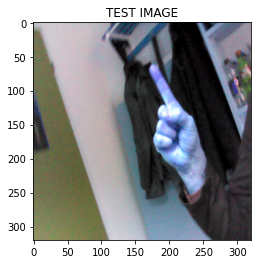

In [ ]:
plt.imshow(array_to_img(X_test[0]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

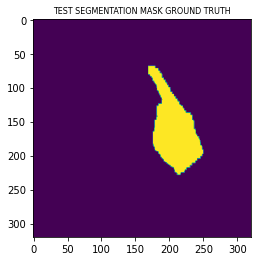

In [ ]:
plt.imshow(array_to_img(Y_test[0]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

In [ ]:
plt.imshow(array_to_img(y_pred[0]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

NameError: ignored

In [ ]:
x_test_single = np.expand_dims(X_test[7], axis = 0)

In [ ]:
import time
start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.9490256309509277 seconds ---
